# Demonstrate the Violation of the CHSH Inequality with the Estimator primitive

In this tutorial, you will run an experiment on a quantum computer to demonstrate the violation of the CHSH inequality with the Estimator primitive. 

The violation of the CHSH inequality is used to show that quantum mechanics is incompatible with local hidden-variable theories. This is an important experiemnt for understanding the foundation of quantum mechanics. Demonstrating this on a quantum computer was a major scientific breakthrough worthy of a high impact journal publication just a few years ago. [citation] It's truly incredible that you can conduct this experiment at the comfort of your home using Qiskit and an IBM Quantum system.

## Before you begin

This tutorial requires a Qiskit Runtime service instance. If you haven't done so already, please follow the [Getting Started Guide](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/getting_started.html) to set one up.

## Background Information

### CHSH Inequality




As an example for using the Sampler and the Estimator primitives from Qiskit Runtime, we are going to demonstrate the violation of the CHSH (named after Clauser, Horne, Shimony, and Holt) inequality. The basis of this experiment is the creation of a entangled pair (we will use a Bell state) on which we measure each qubit on two different bases. If we call the bases for the first qubit $A$ and $a$, and the bases for the second qubit $B$ and $b$, we can then compute the quantity $\langle CHSH \rangle = \langle AB \rangle - \langle Ab \rangle + \langle aB \rangle + \langle ab \rangle$. As we have seen, since each qubit measurement in any of the bases can only yield the result $\pm 1$, we should find that the quantity above is bounded, $|\langle CHSH \rangle| =|\langle AB \rangle - \langle Ab \rangle + \langle aB \rangle + \langle ab \rangle| \leq 2$, if local realism held.


We are going to define two such CHSH quantities, or witnesses: $\langle CHSH1 \rangle = \langle AB \rangle - \langle Ab \rangle + \langle aB \rangle + \langle ab \rangle$ and $\langle CHSH2 \rangle = \langle AB \rangle + \langle Ab \rangle - \langle aB \rangle + \langle ab \rangle$. Then, without losing generality, we will measure the second qubit in the $Z$ and $X$ bases, whereas the first qubit will be measured also in orthogonal bases, but with an angle with respect to the second qubit, which we are going to sweep between $0$ and $2\pi$. **This will also highlight the benefit of using these Runtime primitives for parameterized circuits.**

## Plan

TODO: Add description of the plan for the tutorial

## Step 1: Create CHSH circuits

### Create a parameterized CHSH circuit 

First, we write the circuit with the parameter $\theta$, which we call `theta`. The `Estimator` primitive can enormously simplify circuit building and output analysis by directly providing expectation values of observables. Many problems of interest, especially for near-term applications on noisy systems, can be formulated in terms of expectation values. For maximum generalization, the `Estimator` primitive requires circuits with no measurements.

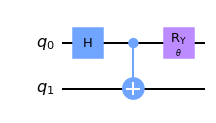

In [1]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit

theta = Parameter('$\\theta$')

chsh_circuits_no_meas = QuantumCircuit(2)
chsh_circuits_no_meas.h(0)
chsh_circuits_no_meas.cx(0, 1)
chsh_circuits_no_meas.ry(theta, 0)
chsh_circuits_no_meas.draw()

### Create a list of phase values to be assigned later

After creating the parameterized CHSH circuit, you will create a list of phase values to be assigned to the circuit in the next step. You can use the code below to create a list of 21 phase values range from $0$ to $2 \pi$ with equal spacing, i.e. $0$, $0.1 \pi$, $0.2 \pi$, ..., $1.9 \pi$, $2 \pi$.

In [2]:
import numpy as np

number_of_phases = 21
phases = np.linspace(0, 2*np.pi, number_of_phases)
# Phases need to be expressed as list of lists in order to work
individual_phases = [[ph] for ph in phases]

## Step 2: Submit the circuits to a quantum computer on the cloud



### Connect to the Qiskit Runtime service  

First, you will connect to the Qiskit Runtime service instance that you created in [the first step](#before-you-begin). We will to run this tutorial on both a simulator and a real quantum system. The simulator results will correspond to results without noise while the experimental results on a real quantum system will correspond to results in the presence of noise.

In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
options_sim = {'backend_name': 'ibmq_qasm_simulator'}  # use the simulator
options_exp = {'backend_name': 'ibmq_qasm_simulator'}  # use a real quantum system TODO change to a real system later

### Run the parameterized circuits using the Estimator primitive 

Now we need observables from which to compute the expectation values.  In our case we are looking at orthogonal bases for each qubit, letting the parameterized $Y-$ rotation for the first qubit sweep the measurement basis nearly continuously with respect to the second qubit basis. We will therefore choose the observables $ZZ$, $ZX$, $XZ$, and $XX$.

In [4]:
from qiskit_ibm_runtime import Estimator
from qiskit.quantum_info import SparsePauliOp

ZZ = SparsePauliOp.from_list([("ZZ", 1)])
ZX = SparsePauliOp.from_list([("ZX", 1)])
XZ = SparsePauliOp.from_list([("XZ", 1)])
XX = SparsePauliOp.from_list([("XX", 1)])

ops = [ZZ, ZX, XZ, XX]
chsh_est_sim = []
chsh_est_exp = []

# Simulator
with Estimator(circuits=chsh_circuits_no_meas, observables=ops,
                service=service, options=options_sim) as estimator:
    for op in ops:
        est_result = estimator(circuits=[0]*len(individual_phases),
                        observables=[op]*len(individual_phases),
                        parameter_values=individual_phases)
        chsh_est_sim.append(est_result)

# Real device
with Estimator(circuits=chsh_circuits_no_meas, observables=ops,
                service=service, options=options_exp) as estimator:
    for op in ops:
        est_result = estimator(circuits=[0]*len(phases),
                            observables=[op]*len(phases),
                            parameter_values=individual_phases)
        chsh_est_exp.append(est_result)

## Step 3: Analyze the results

After running the circuits, we need to build the CHSH witness functions. We first build the quantities $\langle AB \rangle$, $\langle Ab \rangle$, $\langle aB \rangle$, and $\langle ab \rangle$, by looking at the parity of the outcomes for the four families of circuits we built (two measurement bases for each of the two qubits). Then we use those quantities to build the witness functions as defined above.

In [5]:
# <CHSH1> = <AB> - <Ab> + <aB> + <ab>
chsh1_est_sim = chsh_est_sim[0].values - chsh_est_sim[1].values + chsh_est_sim[2].values + chsh_est_sim[3].values
chsh1_est_exp = chsh_est_exp[0].values - chsh_est_exp[1].values + chsh_est_exp[2].values + chsh_est_exp[3].values

# <CHSH2> = <AB> + <Ab> - <aB> + <ab>
chsh2_est_sim = chsh_est_sim[0].values + chsh_est_sim[1].values - chsh_est_sim[2].values + chsh_est_sim[3].values
chsh2_est_exp = chsh_est_exp[0].values + chsh_est_exp[1].values - chsh_est_exp[2].values + chsh_est_exp[3].values

Note that now we do not have to build the observables ourselves because they are returned to us! The computed expectation values are given in `result.values`. What comes back is a very small payload of data.

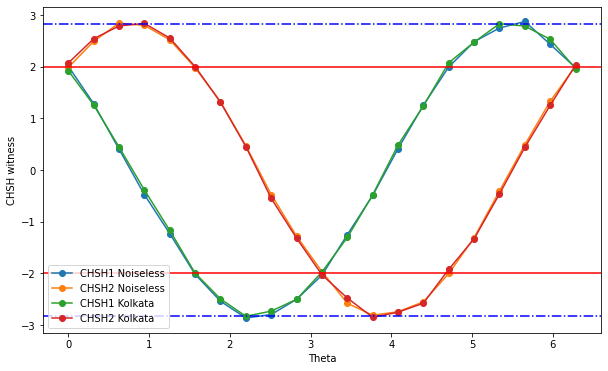

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 6))
plt.plot(phases, chsh1_est_sim, 'o-', label='CHSH1 Noiseless')
plt.plot(phases, chsh2_est_sim, 'o-', label='CHSH2 Noiseless')
plt.plot(phases, chsh1_est_exp, 'o-', label='CHSH1 Kolkata')
plt.plot(phases, chsh2_est_exp, 'o-', label='CHSH2 Kolkata')
plt.axhline(y=2, color='r', linestyle='-')
plt.axhline(y=-2, color='r', linestyle='-')
plt.axhline(y=np.sqrt(2)*2, color='b', linestyle='-.')
plt.axhline(y=-np.sqrt(2)*2, color='b', linestyle='-.')
plt.xlabel('Theta')
plt.ylabel('CHSH witness')
plt.legend()

In the figure above, the red lines delimit the classical bound and the dash-dotted blue lines delimit the quantum bound. We indeed observe a violation of the $CHSH$ inequality in our real device!

## Summary

TODO: Add summary

## Reference

TODO: Add references

## Qiskit versions and copyright

In [7]:
import qiskit_ibm_runtime
qiskit_ibm_runtime.version.get_version_info()

'0.6.1'

In [8]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright